In [1]:
# Install Swifter using pip
# This package helps optimize DataFrame operations
!pip install swifter



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install wordcloud



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Importing important libraries 

import json
import numpy as np
import pandas as pd
import swifter
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import NMF

import warnings
warnings.filterwarnings('ignore')

In [2]:
  <span style="font-size:50px">Loading the dataset</span>


SyntaxError: invalid syntax (1994236512.py, line 1)

In [8]:
f = open('complaints-2021-05-14_08_16.json')

data = json.load(f)
df=pd.json_normalize(data)

In [9]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

<span style="font-size:50px">Preparing the dataset </span>

In [10]:
df.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'tag'}, inplace=True)

In [11]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'tag',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely', 'complaints_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [12]:
df = df[['complaints_what_happened', 'tag']]

In [13]:
df.shape

(78313, 2)

In [14]:
df.columns

Index(['complaints_what_happened', 'tag'], dtype='object')

In [15]:
df = df[df['complaints_what_happened'].astype(bool)]
df

,complaints_what_happened,tag
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account
...,...,...
78303,After being a Chase Card customer for well ove...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card


<span style="font-size:50px"> Making the texts for topic modeling </span>

In [16]:
# Function to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() 
    text = re.sub(r'\s\{\$\S*', '',text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\(\w*\)', '', text) 
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) 
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) 
    text = re.sub(r'\d+\s', '', text) 
    text = re.sub(r' +', ' ',text) 
    return text


In [20]:
# Apply data cleaning to the complaints_what_happened column

df['complaints'] = df['complaints_what_happened'].apply(clean_data)
df.head()

,complaints_what_happened,tag,complaints
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,i upgraded my card in and was told by the agen...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card was reported on however fraudulent ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,my grand son give me check for i deposit it in...


In [18]:
# Function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [21]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [22]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['complaints'].apply(lemmatization)})

In [23]:
df_clean.head

<bound method NDFrame.head of                                               complaints  \
1      good morning my name is and i appreciate it if...   
2      i upgraded my card in and was told by the agen...   
10     chase card was reported on however fraudulent ...   
11     on while trying to book a ticket i came across...   
14     my grand son give me check for i deposit it in...   
...                                                  ...   
78303  after being a chase card customer for well ove...   
78309  on wednesday i called chas my visa credit card...   
78310  i am not familiar with pay and did not underst...   
78311  i have had flawless credit for yrs i ve had ch...   
78312  roughly years ago i closed out my accounts wit...   

                                              lemmatized  
1      good morning my name is and i appreciate it if...  
2      i upgraded my card in and wa told by the agent...  
10     chase card wa reported on however fraudulent a...  
11     on whi

In [24]:
# Writing the function to remove the POS tags from the clean_df .
def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.


df_clean

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...


In [ ]:
df_clean.head

<span style="font-size:50px; font-weight:bold;">
Doing some Exploratory Data Analysis
</span>


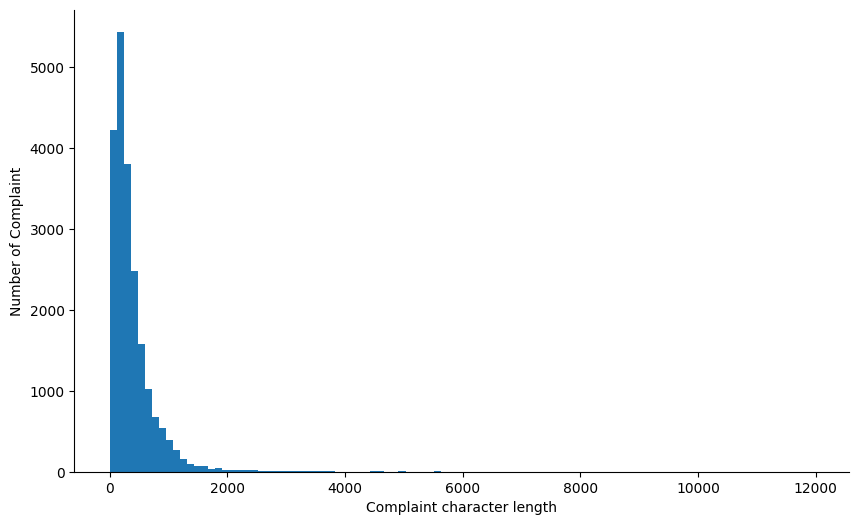

In [31]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

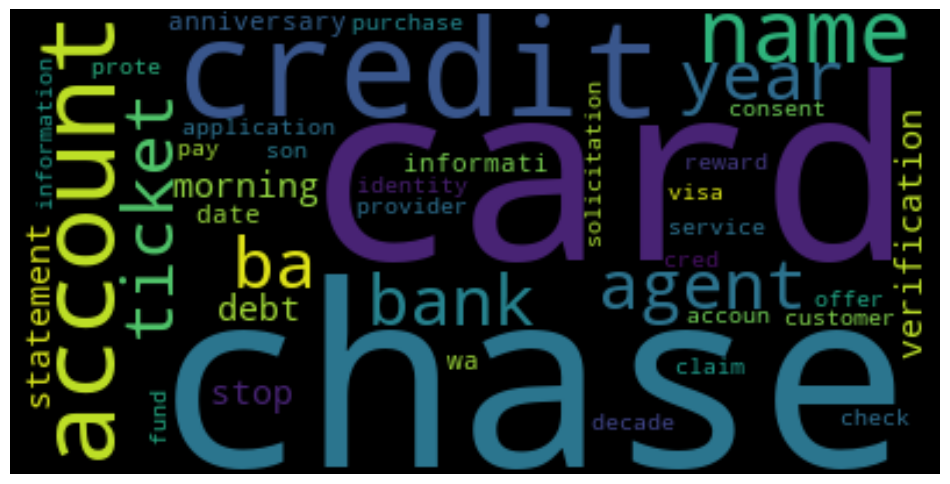

In [32]:
# Top 40 words frequency wise wordcloud
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...


In [34]:
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaints'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram



In [36]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [37]:
df_unigram = top_grams(1)
df_unigram.head(10)

,frequency,unigram
0,80853,chase
1,42751,account
2,32812,credit
3,26946,card
4,26765,bank
5,20364,would
6,16383,told
7,14127,payment
8,13477,called
9,12877,received


<span style="font-size:50px; font-weight:bold;">
Features Extraction
</span>

In [39]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints'])

<span style="font-size:50px; font-weight:bold;">
Manual topic modelling taking one one topic
</span>

In [44]:
 #Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [46]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())


14985

In [49]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


In [55]:
# Crreating the topic for each complaints
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4], shape=(21072,))

In [56]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [57]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3


In [58]:
# Print the first 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,0
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,0
40,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,0
43,chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase email today title information change cha...,chase email today title information change cha...,0
26,i have reached out to several times in attempt...,i have reached out to several time in attempt ...,time attempt inquiry creditor inquiry report a...,time attempt inquiry creditor inquiry report a...,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,1
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1


In [59]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [60]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgage/Loan
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,Account Services
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,Others
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Others
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Credit card or prepaid card
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Others
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Account Services
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Account Services
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...,Theft/Dispute Reporting


<span style="font-size:50px; font-weight:bold;">
Supervised model to predict any complaints to the relevant topic
</span>

In [61]:
# Create the dictionary again of Topic names and Topics

Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [62]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemmatized', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [63]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if...,2
2,i upgraded my card in and was told by the agen...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
14,my grand son give me check for i deposit it in...,3
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit card...,0
78310,i am not familiar with pay and did not underst...,0
78311,i have had flawless credit for yrs i ve had ch...,4


In [64]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

<span style="font-size:50px; font-weight:bold;">
Applying logistic regression modeling on the training data 
</span>

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [69]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [70]:

lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       944
           1       0.96      0.95      0.96       914
           2       0.98      0.95      0.96       714
           3       0.94      0.97      0.96      1123
           4       0.97      0.90      0.93       520

    accuracy                           0.95      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215



In [71]:
df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


<span style="font-size:30px; font-weight:bold;">
As we can see here logistic regression is performing well with 0.95 accuracy .
</span>